# Call Volume Prediction with RNN specifically LSTM and GRU

# Importing libraries 

In [1]:
import tensorflow as tf
# Ensure eager execution is enabled by default
tf.config.run_functions_eagerly(True)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
#Importing dataset

data = pd.read_csv('call_data.csv')
print(data.shape)

(35588, 11)


In [3]:
data

,Date_Time,Day_Of_The_Week,Call_Volume,Calls_Dropped,Suspensions,Holiday,Campaign,Service_Outage,Agents_On_Duty,Svc_Level,Transferred_Calls_Percentage
0,1/1/2000 0:00,Saturday,109,37,NO,YES,NO,YES,18,92,57
1,1/1/2000 6:00,Saturday,110,35,NO,YES,NO,NO,18,95,60
2,1/1/2000 12:00,Saturday,105,48,NO,YES,NO,NO,18,84,61
3,1/1/2000 18:00,Saturday,101,29,NO,YES,NO,NO,18,81,55
4,1/2/2000 0:00,Sunday,16,4,NO,NO,NO,NO,16,93,57
...,...,...,...,...,...,...,...,...,...,...,...
35583,5/9/2024 18:00,Thursday,545,45,NO,NO,NO,YES,15,94,64
35584,5/10/2024 0:00,Friday,585,30,NO,NO,YES,NO,16,86,90
35585,5/10/2024 6:00,Friday,678,51,NO,NO,YES,YES,16,85,62
35586,5/10/2024 12:00,Friday,588,55,NO,NO,YES,YES,17,86,61


# Handling Missing Values 

In [4]:
# checking for missing values

print(data.isnull().sum())

Date_Time                       0
Day_Of_The_Week                 0
Call_Volume                     0
Calls_Dropped                   0
Suspensions                     0
Holiday                         0
Campaign                        0
Service_Outage                  0
Agents_On_Duty                  0
Svc_Level                       0
Transferred_Calls_Percentage    0
dtype: int64


In [5]:
# Perfoming data imputation 
data.loc[:, 'Call_Volume'] = data['Call_Volume'].fillna(data['Call_Volume'].median())
data.loc[:, 'Calls_Dropped'] = data['Calls_Dropped'].fillna(data['Calls_Dropped'].median())
data.loc[:, 'Holiday'] = data['Holiday'].fillna(data['Holiday'].mode()[0])
data.loc[:, 'Service_Outage'] = data['Service_Outage'].fillna(data['Service_Outage'].mode()[0])

In [6]:
# checking for missing values

print(data.isnull().sum())

Date_Time                       0
Day_Of_The_Week                 0
Call_Volume                     0
Calls_Dropped                   0
Suspensions                     0
Holiday                         0
Campaign                        0
Service_Outage                  0
Agents_On_Duty                  0
Svc_Level                       0
Transferred_Calls_Percentage    0
dtype: int64


# Converting the following features to categorical data

In [7]:
data["Suspensions"] = data["Suspensions"].map({'YES': 1, 'NO': 0})
data["Service_Outage"] = data["Service_Outage"].map({'YES': 1, 'NO': 0})
data["Campaign"] = data["Campaign"].map({'YES': 1, 'NO': 0})
data["Holiday"] = data["Holiday"].map({'YES': 1, 'NO': 0})

data

,Date_Time,Day_Of_The_Week,Call_Volume,Calls_Dropped,Suspensions,Holiday,Campaign,Service_Outage,Agents_On_Duty,Svc_Level,Transferred_Calls_Percentage
0,1/1/2000 0:00,Saturday,109,37,0,1,0,1,18,92,57
1,1/1/2000 6:00,Saturday,110,35,0,1,0,0,18,95,60
2,1/1/2000 12:00,Saturday,105,48,0,1,0,0,18,84,61
3,1/1/2000 18:00,Saturday,101,29,0,1,0,0,18,81,55
4,1/2/2000 0:00,Sunday,16,4,0,0,0,0,16,93,57
...,...,...,...,...,...,...,...,...,...,...,...
35583,5/9/2024 18:00,Thursday,545,45,0,0,0,1,15,94,64
35584,5/10/2024 0:00,Friday,585,30,0,0,1,0,16,86,90
35585,5/10/2024 6:00,Friday,678,51,0,0,1,1,16,85,62
35586,5/10/2024 12:00,Friday,588,55,0,0,1,1,17,86,61


# Convert 'Day of the Week' to one-hot encoding

In [8]:

data = pd.get_dummies(data, columns=['Day_Of_The_Week'], prefix='day')

data

,Date_Time,Call_Volume,Calls_Dropped,Suspensions,Holiday,Campaign,Service_Outage,Agents_On_Duty,Svc_Level,Transferred_Calls_Percentage,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,1/1/2000 0:00,109,37,0,1,0,1,18,92,57,False,False,True,False,False,False,False
1,1/1/2000 6:00,110,35,0,1,0,0,18,95,60,False,False,True,False,False,False,False
2,1/1/2000 12:00,105,48,0,1,0,0,18,84,61,False,False,True,False,False,False,False
3,1/1/2000 18:00,101,29,0,1,0,0,18,81,55,False,False,True,False,False,False,False
4,1/2/2000 0:00,16,4,0,0,0,0,16,93,57,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35583,5/9/2024 18:00,545,45,0,0,0,1,15,94,64,False,False,False,False,True,False,False
35584,5/10/2024 0:00,585,30,0,0,1,0,16,86,90,True,False,False,False,False,False,False
35585,5/10/2024 6:00,678,51,0,0,1,1,16,85,62,True,False,False,False,False,False,False
35586,5/10/2024 12:00,588,55,0,0,1,1,17,86,61,True,False,False,False,False,False,False


# Convert boolean values (True and False) to 1s and 0s

In [9]:

data[['day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday']] = data[['day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday']].astype(int)

#Printing only specific columns
data[['day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday']]

,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
35583,0,0,0,0,1,0,0
35584,1,0,0,0,0,0,0
35585,1,0,0,0,0,0,0
35586,1,0,0,0,0,0,0


In [10]:
data

,Date_Time,Call_Volume,Calls_Dropped,Suspensions,Holiday,Campaign,Service_Outage,Agents_On_Duty,Svc_Level,Transferred_Calls_Percentage,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,1/1/2000 0:00,109,37,0,1,0,1,18,92,57,0,0,1,0,0,0,0
1,1/1/2000 6:00,110,35,0,1,0,0,18,95,60,0,0,1,0,0,0,0
2,1/1/2000 12:00,105,48,0,1,0,0,18,84,61,0,0,1,0,0,0,0
3,1/1/2000 18:00,101,29,0,1,0,0,18,81,55,0,0,1,0,0,0,0
4,1/2/2000 0:00,16,4,0,0,0,0,16,93,57,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35583,5/9/2024 18:00,545,45,0,0,0,1,15,94,64,0,0,0,0,1,0,0
35584,5/10/2024 0:00,585,30,0,0,1,0,16,86,90,1,0,0,0,0,0,0
35585,5/10/2024 6:00,678,51,0,0,1,1,16,85,62,1,0,0,0,0,0,0
35586,5/10/2024 12:00,588,55,0,0,1,1,17,86,61,1,0,0,0,0,0,0


# Checking for Outliers

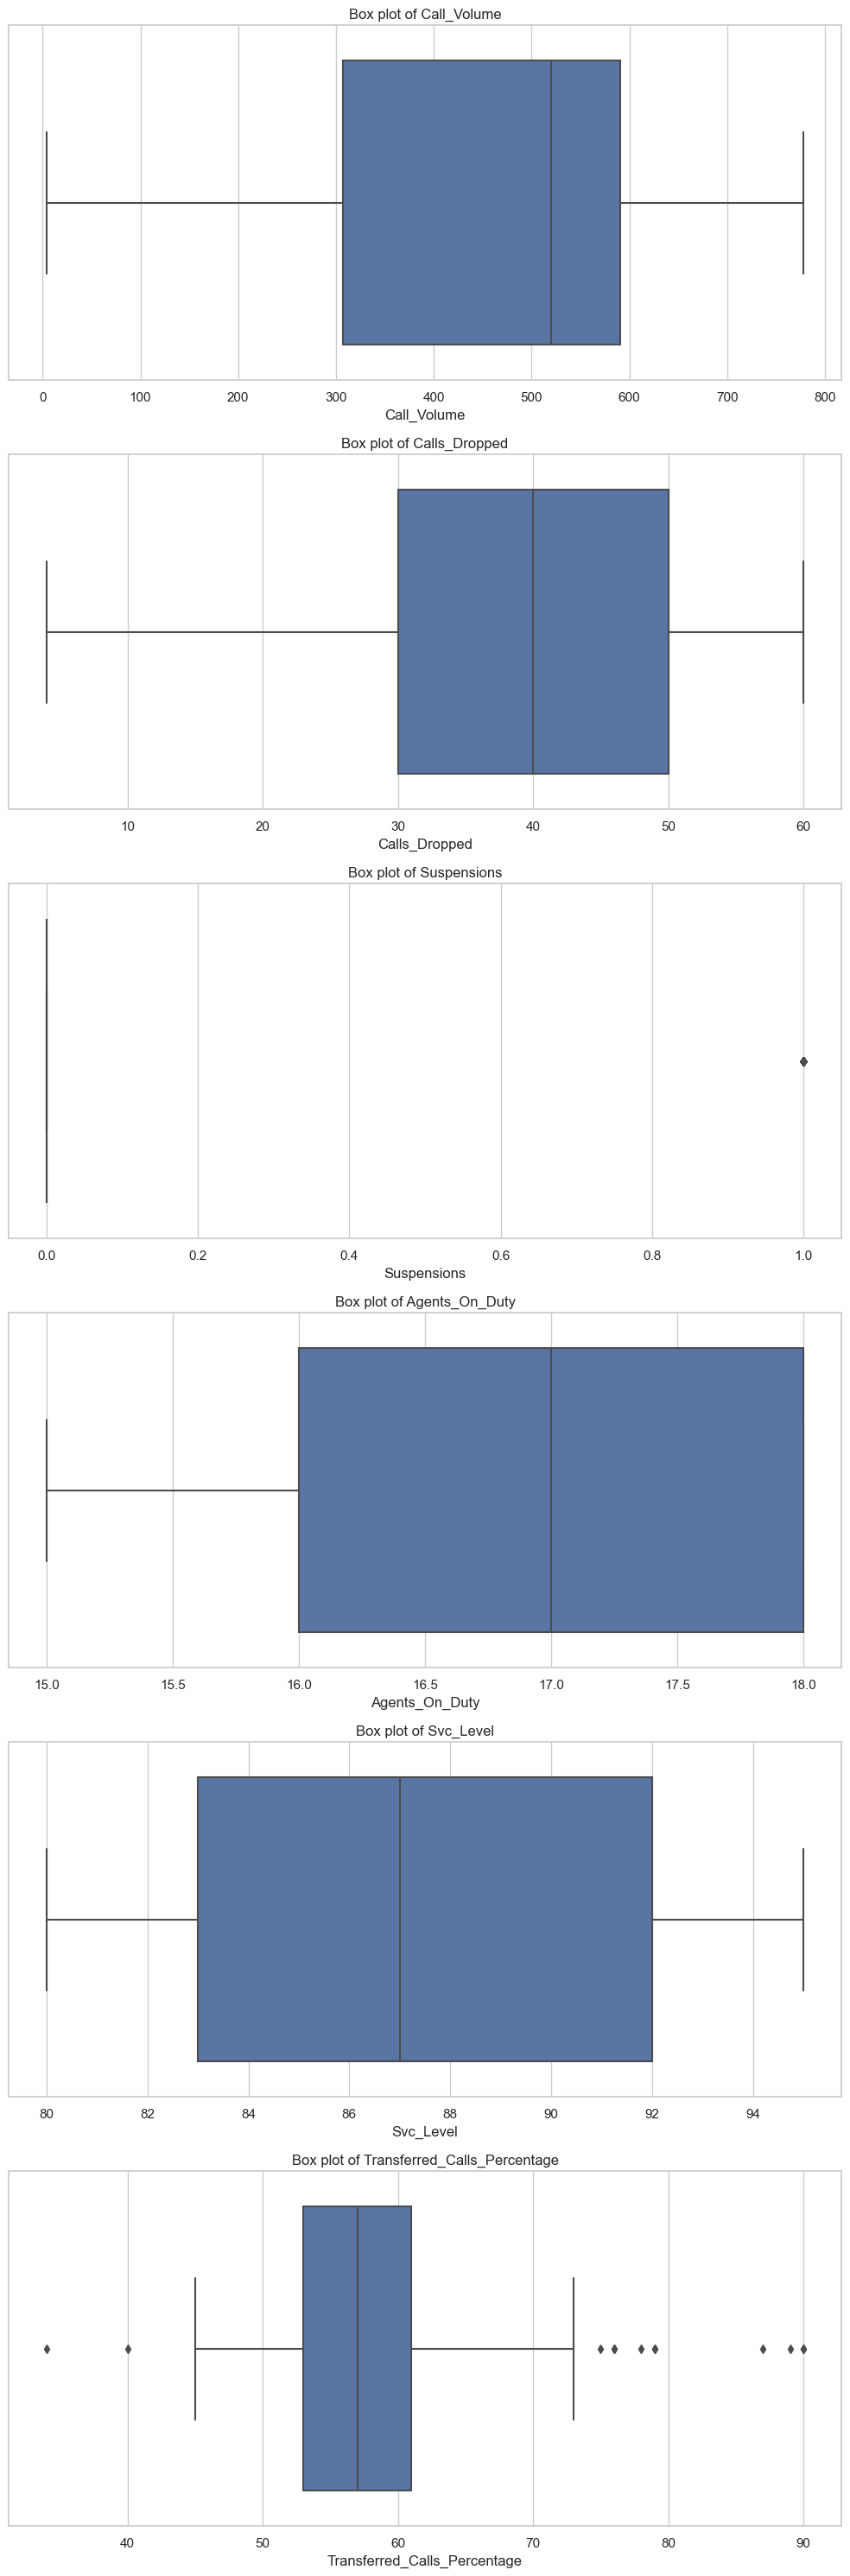

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert columns to numeric 
numeric_columns = ['Call_Volume', 'Calls_Dropped', 'Suspensions', 'Agents_On_Duty', 'Svc_Level', 'Transferred_Calls_Percentage']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

sns.set(style="whitegrid")

# subplots to display box plots for each column
fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(10, 5 * len(numeric_columns)))

# Iterate through each column and create box plot
for i, column in enumerate(numeric_columns):
    sns.boxplot(x=data[column], ax=axes[i])
    axes[i].set_title(f'Box plot of {column}')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

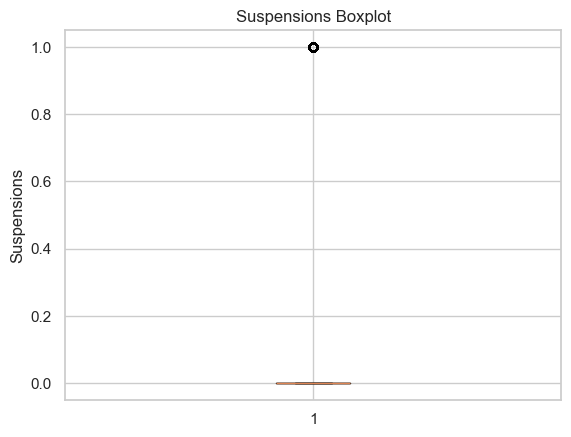

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

suspensions_data = data['Suspensions']

# Create Boxplot
plt.boxplot(suspensions_data)
plt.title('Suspensions Boxplot')
plt.ylabel('Suspensions')
plt.show()


In [13]:
# Handling outliers

Q1 = data['Transferred_Calls_Percentage'].quantile(0.25)
Q3 = data['Transferred_Calls_Percentage'].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds for outliers
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR

# Impute outliers with the median
median_value = data['Transferred_Calls_Percentage'].median()
data.loc[data['Transferred_Calls_Percentage'] < lower_threshold, 'Transferred_Calls_Percentage'] = median_value
data.loc[data['Transferred_Calls_Percentage'] > upper_threshold, 'Transferred_Calls_Percentage'] = median_value


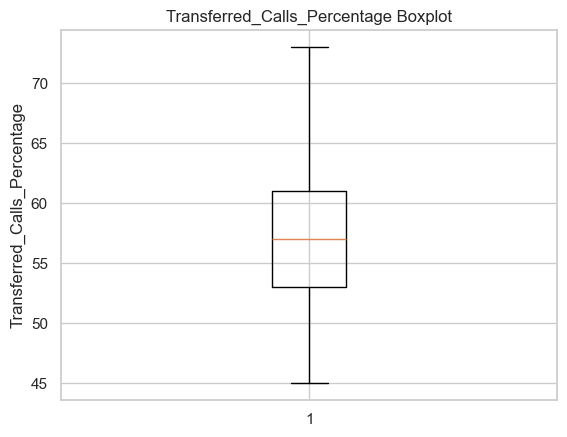

In [14]:
# boxplot for Transferred_Calls_Percentage
suspensions_data = data['Transferred_Calls_Percentage']

# Create Boxplot
plt.boxplot(suspensions_data)
plt.title('Transferred_Calls_Percentage Boxplot')
plt.ylabel('Transferred_Calls_Percentage')
plt.show()

# Applying Feature scaling 

In [15]:
# Step 4: Data normalization

#MinMaxScaler
scaler = MinMaxScaler()

# Creating a new column for call volume (Scaled)
data['Call_Volume_Scaled'] = scaler.fit_transform(data[['Call_Volume']]) 

#Features to scale
features_to_scale = ['Calls_Dropped', 'Agents_On_Duty', 'Svc_Level', 'Transferred_Calls_Percentage']

# Applying Min-Max scaling to the specified features
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

data

,Date_Time,Call_Volume,Calls_Dropped,Suspensions,Holiday,Campaign,Service_Outage,Agents_On_Duty,Svc_Level,Transferred_Calls_Percentage,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,Call_Volume_Scaled
0,1/1/2000 0:00,109,0.589286,0,1,0,1,1.000000,0.800000,0.428571,0,0,1,0,0,0,0,0.135659
1,1/1/2000 6:00,110,0.553571,0,1,0,0,1.000000,1.000000,0.535714,0,0,1,0,0,0,0,0.136951
2,1/1/2000 12:00,105,0.785714,0,1,0,0,1.000000,0.266667,0.571429,0,0,1,0,0,0,0,0.130491
3,1/1/2000 18:00,101,0.446429,0,1,0,0,1.000000,0.066667,0.357143,0,0,1,0,0,0,0,0.125323
4,1/2/2000 0:00,16,0.000000,0,0,0,0,0.333333,0.866667,0.428571,0,0,0,1,0,0,0,0.015504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35583,5/9/2024 18:00,545,0.732143,0,0,0,1,0.000000,0.933333,0.678571,0,0,0,0,1,0,0,0.698966
35584,5/10/2024 0:00,585,0.464286,0,0,1,0,0.333333,0.400000,0.428571,1,0,0,0,0,0,0,0.750646
35585,5/10/2024 6:00,678,0.839286,0,0,1,1,0.333333,0.333333,0.607143,1,0,0,0,0,0,0,0.870801
35586,5/10/2024 12:00,588,0.910714,0,0,1,1,0.666667,0.400000,0.571429,1,0,0,0,0,0,0,0.754522


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35588 entries, 0 to 35587
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date_Time                     35588 non-null  object 
 1   Call_Volume                   35588 non-null  int64  
 2   Calls_Dropped                 35588 non-null  float64
 3   Suspensions                   35588 non-null  int64  
 4   Holiday                       35588 non-null  int64  
 5   Campaign                      35588 non-null  int64  
 6   Service_Outage                35588 non-null  int64  
 7   Agents_On_Duty                35588 non-null  float64
 8   Svc_Level                     35588 non-null  float64
 9   Transferred_Calls_Percentage  35588 non-null  float64
 10  day_Friday                    35588 non-null  int32  
 11  day_Monday                    35588 non-null  int32  
 12  day_Saturday                  35588 non-null  int32  
 13  d

# Conversion of Date time to datetime type & set it as index

In [17]:
# Converting Date time column to datetime type
data['Date_Time'] = pd.to_datetime(data['Date_Time'])

# Set 'Date time' as the index
data.set_index('Date_Time', inplace=True)

#data = data.reset_index()

data

,Call_Volume,Calls_Dropped,Suspensions,Holiday,Campaign,Service_Outage,Agents_On_Duty,Svc_Level,Transferred_Calls_Percentage,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,Call_Volume_Scaled
Date_Time,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,109,0.589286,0,1,0,1,1.000000,0.800000,0.428571,0,0,1,0,0,0,0,0.135659
2000-01-01 06:00:00,110,0.553571,0,1,0,0,1.000000,1.000000,0.535714,0,0,1,0,0,0,0,0.136951
2000-01-01 12:00:00,105,0.785714,0,1,0,0,1.000000,0.266667,0.571429,0,0,1,0,0,0,0,0.130491
2000-01-01 18:00:00,101,0.446429,0,1,0,0,1.000000,0.066667,0.357143,0,0,1,0,0,0,0,0.125323
2000-01-02 00:00:00,16,0.000000,0,0,0,0,0.333333,0.866667,0.428571,0,0,0,1,0,0,0,0.015504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-09 18:00:00,545,0.732143,0,0,0,1,0.000000,0.933333,0.678571,0,0,0,0,1,0,0,0.698966
2024-05-10 00:00:00,585,0.464286,0,0,1,0,0.333333,0.400000,0.428571,1,0,0,0,0,0,0,0.750646
2024-05-10 06:00:00,678,0.839286,0,0,1,1,0.333333,0.333333,0.607143,1,0,0,0,0,0,0,0.870801


In [18]:
data.describe()

,Call_Volume,Calls_Dropped,Suspensions,Holiday,Campaign,Service_Outage,Agents_On_Duty,Svc_Level,Transferred_Calls_Percentage,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,Call_Volume_Scaled
count,35588.000000,35588.000000,35588.00000,35588.000000,35588.000000,35588.000000,35588.000000,35588.000000,35588.000000,35588.000000,35588.000000,35588.000000,35588.000000,35588.000000,35588.000000,35588.000000,35588.000000
mean,426.708160,0.644922,0.14311,0.038440,0.285714,0.301028,0.501752,0.498902,0.445967,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.546135
std,211.934909,0.210615,0.35019,0.192259,0.451760,0.458711,0.373031,0.307447,0.164582,0.349932,0.349932,0.349932,0.349932,0.349932,0.349932,0.349932,0.273818
min,4.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,307.000000,0.464286,0.00000,0.000000,0.000000,0.000000,0.333333,0.200000,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.391473
50%,520.000000,0.642857,0.00000,0.000000,0.000000,0.000000,0.666667,0.466667,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667
75%,591.000000,0.821429,0.00000,0.000000,1.000000,1.000000,1.000000,0.800000,0.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.758398
max,778.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Distribution of each variable

array([[<Axes: title={'center': 'Call_Volume'}>,
        <Axes: title={'center': 'Calls_Dropped'}>,
        <Axes: title={'center': 'Suspensions'}>,
        <Axes: title={'center': 'Holiday'}>],
       [<Axes: title={'center': 'Campaign'}>,
        <Axes: title={'center': 'Service_Outage'}>,
        <Axes: title={'center': 'Agents_On_Duty'}>,
        <Axes: title={'center': 'Svc_Level'}>],
       [<Axes: title={'center': 'Transferred_Calls_Percentage'}>,
        <Axes: title={'center': 'day_Friday'}>,
        <Axes: title={'center': 'day_Monday'}>,
        <Axes: title={'center': 'day_Saturday'}>],
       [<Axes: title={'center': 'day_Sunday'}>,
        <Axes: title={'center': 'day_Thursday'}>,
        <Axes: title={'center': 'day_Tuesday'}>,
        <Axes: title={'center': 'day_Wednesday'}>],
       [<Axes: title={'center': 'Call_Volume_Scaled'}>, <Axes: >,
        <Axes: >, <Axes: >]], dtype=object)

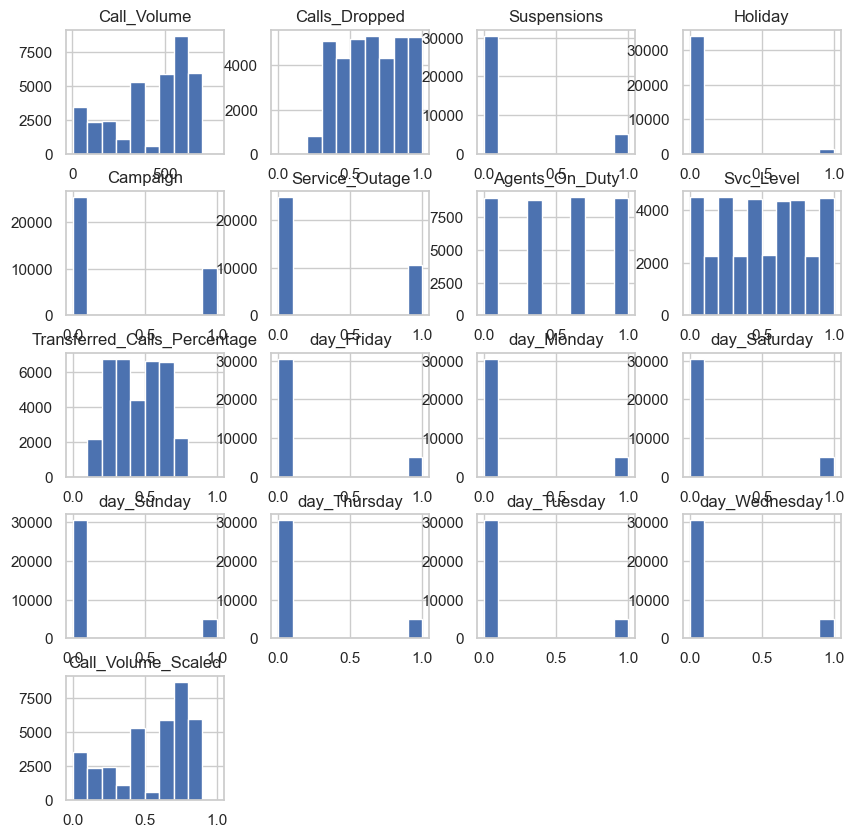

In [19]:
data.hist(figsize=(10,10))

C:\Users\kudak\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


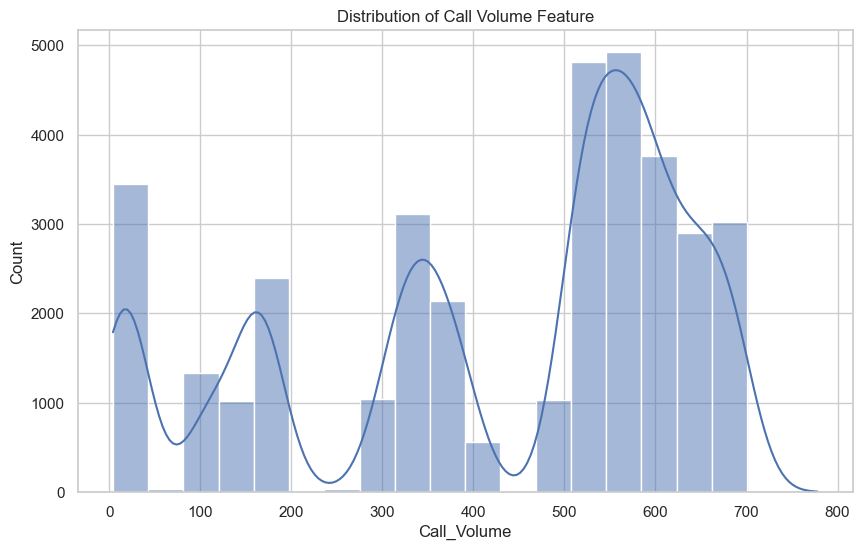

In [20]:
# Distribution Call Volume

plt.figure(figsize=(10, 6))
sns.histplot(data['Call_Volume'], bins=20, kde=True)
plt.title('Distribution of Call Volume Feature')
plt.xlabel('Call_Volume')
plt.show()

C:\Users\kudak\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kudak\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


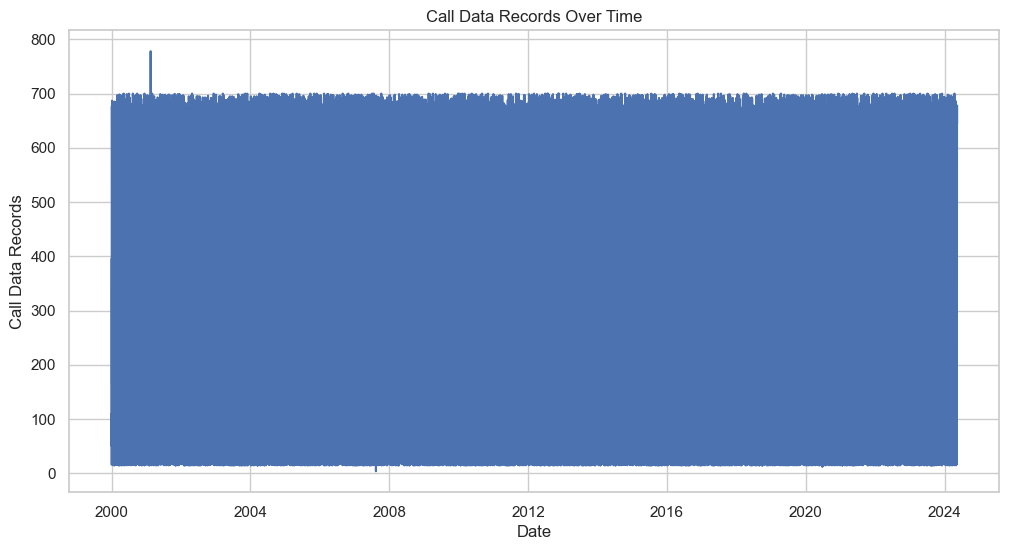

In [21]:
#Call Data Records Over Time 

plt.figure(figsize=(12, 6))
sns.lineplot(data=data['Call_Volume'])
plt.title('Call Data Records Over Time')
plt.xlabel('Date')
plt.ylabel('Call Data Records')
plt.show()

# Correlation Analysis

In [22]:

cor_matrix = data[['Call_Volume', 'Calls_Dropped', 'Holiday', 'Campaign', 
                              'Service_Outage', 'Agents_On_Duty', 'Svc_Level',
                              'Transferred_Calls_Percentage', 'Suspensions']].corr()
cor_matrix

,Call_Volume,Calls_Dropped,Holiday,Campaign,Service_Outage,Agents_On_Duty,Svc_Level,Transferred_Calls_Percentage,Suspensions
Call_Volume,1.000000,0.004076,-0.299655,0.457438,0.453762,0.005315,-0.003454,-0.002196,0.203137
Calls_Dropped,0.004076,1.000000,0.001856,-0.002357,0.000888,0.002477,0.003250,0.012634,0.000803
Holiday,-0.299655,0.001856,1.000000,0.000370,-0.000257,-0.008644,0.006545,-0.000105,0.000094
Campaign,0.457438,-0.002357,0.000370,1.000000,0.013579,0.000865,-0.004958,-0.000993,-0.257577
Service_Outage,0.453762,0.000888,-0.000257,0.013579,1.000000,0.003788,-0.005275,-0.006381,-0.003873
Agents_On_Duty,0.005315,0.002477,-0.008644,0.000865,0.003788,1.000000,-0.014224,-0.001008,0.007295
Svc_Level,-0.003454,0.003250,0.006545,-0.004958,-0.005275,-0.014224,1.000000,0.000592,0.006009
Transferred_Calls_Percentage,-0.002196,0.012634,-0.000105,-0.000993,-0.006381,-0.001008,0.000592,1.000000,0.005473
Suspensions,0.203137,0.000803,0.000094,-0.257577,-0.003873,0.007295,0.006009,0.005473,1.000000


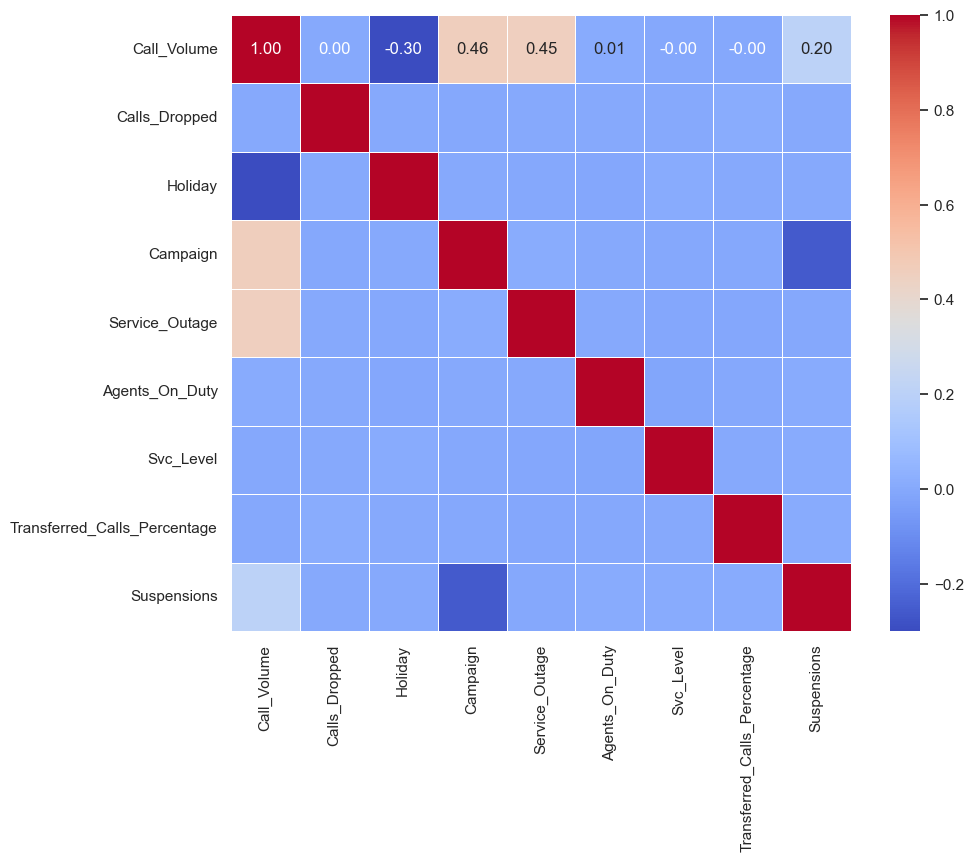

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation Analysis
cor_matrix = data[['Call_Volume', 'Calls_Dropped', 'Holiday', 'Campaign', 
                   'Service_Outage', 'Agents_On_Duty', 'Svc_Level',
                   'Transferred_Calls_Percentage', 'Suspensions']].corr()

plt.figure(figsize=(10, 8))

sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.show()

# Split data into training and test set based on dates

In [24]:
'''from sklearn.model_selection import train_test_split

# Assume 'data' is your original DataFrame

# Define features and target variable for the entire dataset
X = data.drop(['Call_Volume','Calls_Dropped','Holiday','Transferred_Calls_Percentage','Svc_Level','day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday'], axis=1)
y = data['Call_Volume']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("Training set: X_train.shape =", X_train.shape, "y_train.shape =", y_train.shape)
print("Testing set: X_test.shape =", X_test.shape, "y_test.shape =", y_test.shape)'''

'from sklearn.model_selection import train_test_split\n\n# Assume \'data\' is your original DataFrame\n\n# Define features and target variable for the entire dataset\nX = data.drop([\'Call_Volume\',\'Calls_Dropped\',\'Holiday\',\'Transferred_Calls_Percentage\',\'Svc_Level\',\'day_Friday\', \'day_Monday\', \'day_Saturday\', \'day_Sunday\', \'day_Thursday\', \'day_Tuesday\', \'day_Wednesday\'], axis=1)\ny = data[\'Call_Volume\']\n\n# Split the data into training and testing sets (80% train, 20% test)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Print the shapes of the resulting sets\nprint("Training set: X_train.shape =", X_train.shape, "y_train.shape =", y_train.shape)\nprint("Testing set: X_test.shape =", X_test.shape, "y_test.shape =", y_test.shape)'

In [25]:
from sklearn.model_selection import train_test_split

data.index = pd.to_datetime(data.index)

# Splitting based on dates
train_set = data[data.index.year <= 2018]
test_set = data[data.index.year > 2018]

# Define features and target variable for training set
X_train = train_set.drop(['Call_Volume','Call_Volume_Scaled','Calls_Dropped','Holiday','Transferred_Calls_Percentage','Svc_Level','day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday'], axis=1)
y_train = train_set['Call_Volume']

# Define features and target variable for testing set
X_test = test_set.drop(['Call_Volume','Call_Volume_Scaled','Calls_Dropped','Holiday','Transferred_Calls_Percentage','Svc_Level','day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday'], axis=1)
y_test = test_set['Call_Volume']

# Print the shapes of the resulting sets
print("Training set: X_train.shape =", X_train.shape, "y_train.shape =", y_train.shape)
print("Testing set: X_test.shape =", X_test.shape, "y_test.shape =", y_test.shape)

Training set: X_train.shape = (27760, 4) y_train.shape = (27760,)
Testing set: X_test.shape = (7828, 4) y_test.shape = (7828,)


In [26]:
# inspecting the remaining features

print("Remaining features in X_train:", X_train.columns)
print("Remaining features in X_test:", X_test.columns)

Remaining features in X_train: Index(['Suspensions', 'Campaign', 'Service_Outage', 'Agents_On_Duty'], dtype='object')
Remaining features in X_test: Index(['Suspensions', 'Campaign', 'Service_Outage', 'Agents_On_Duty'], dtype='object')


In [27]:
#Checking the index of the target variable

target_variable = 'Call_Volume' 

# Check the column names
column_names = data.columns
target_variable_index = column_names.get_loc(target_variable)

print(f"The index of the target variable '{target_variable}' is: {target_variable_index}")


The index of the target variable 'Call_Volume' is: 0


# Sequences for LSTM / GRU

In [28]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:(i + seq_length), :].values)
        y.append(data.iloc[i + seq_length, 0])  
    return np.array(X), np.array(y)

# Set sequence length
sequence_length = 12

# sequences for LSTM/GRU for training and testing sets
X_train_seq, y_train_seq = create_sequences(X_train, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, sequence_length)

# Build LSTM model

In [29]:

model_lstm = Sequential()
model_lstm.add(LSTM(25, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Adam(), loss='mse', metrics=['accuracy'])

# Train LSTM Model

In [30]:
# Train LSTM model with sequences

lstm_history = model_lstm.fit(X_train_seq, y_train_seq, epochs=50, batch_size=64, validation_data=(X_test_seq, y_test_seq))

Epoch 1/50


C:\Users\kudak\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



434/434 [==============================] - 68s 155ms/step - loss: 0.0532 - accuracy: 0.9364 - val_loss: 0.0267 - val_accuracy: 0.9643
Epoch 2/50
434/434 [==============================] - 68s 157ms/step - loss: 0.0230 - accuracy: 0.9638 - val_loss: 0.0190 - val_accuracy: 0.9648
Epoch 3/50
434/434 [==============================] - 67s 155ms/step - loss: 0.0200 - accuracy: 0.9630 - val_loss: 0.0233 - val_accuracy: 0.9640
Epoch 4/50
434/434 [==============================] - 67s 155ms/step - loss: 0.0192 - accuracy: 0.9645 - val_loss: 0.0184 - val_accuracy: 0.9629
Epoch 5/50
434/434 [==============================] - 68s 157ms/step - loss: 0.0188 - accuracy: 0.9649 - val_loss: 0.0180 - val_accuracy: 0.9666
Epoch 6/50
434/434 [==============================] - 67s 155ms/step - loss: 0.0189 - accuracy: 0.9663 - val_loss: 0.0185 - val_accuracy: 0.9646
Epoch 7/50
434/434 [==============================] - 68s 157ms/step - loss: 0.0187 - accuracy: 0.9641 - val_loss: 0.0185 - val_accuracy: 0.

# Loss and Val Loss 

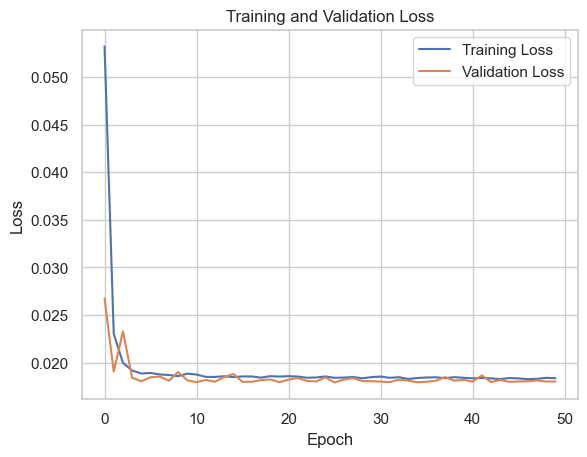

In [41]:
# training loss
plt.plot(lstm_history.history['loss'], label='Training Loss')

# validation loss
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

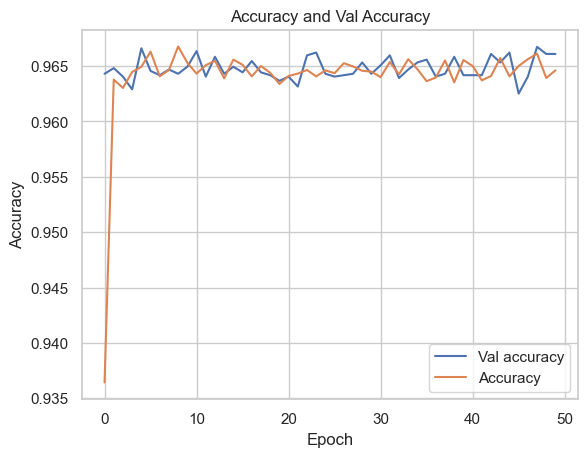

In [42]:
# Both Accuracy
plt.plot(lstm_history.history['val_accuracy'], label='Val accuracy')

# validation loss
plt.plot(lstm_history.history['accuracy'], label='Accuracy')

plt.title('Accuracy and Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [43]:
pred_lstm = model_lstm.predict(X_test_seq)

245/245 [==============================] - 7s 29ms/step


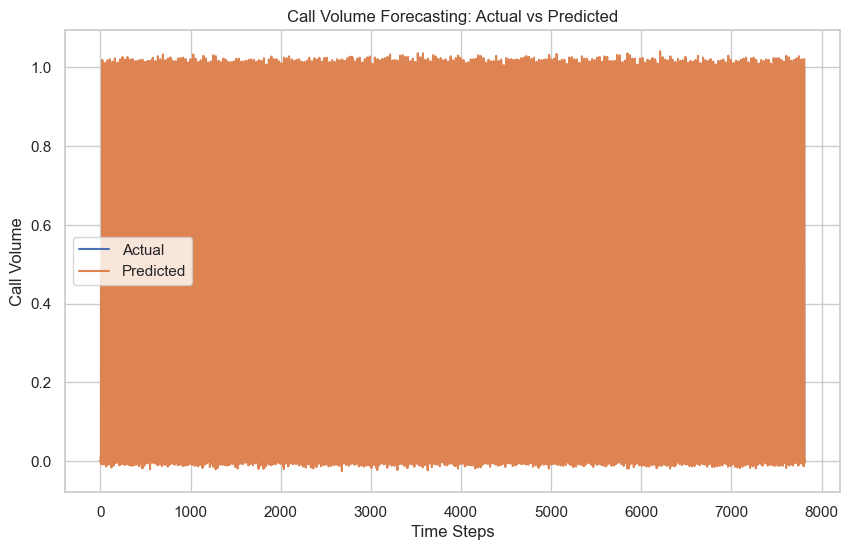

In [44]:
import matplotlib.pyplot as plt

# Plot actual vs predicted call volumes
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(pred_lstm, label='Predicted')
plt.title('Call Volume Forecasting: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Call Volume')
plt.legend()
plt.show()

245/245 [==============================] - 7s 30ms/step


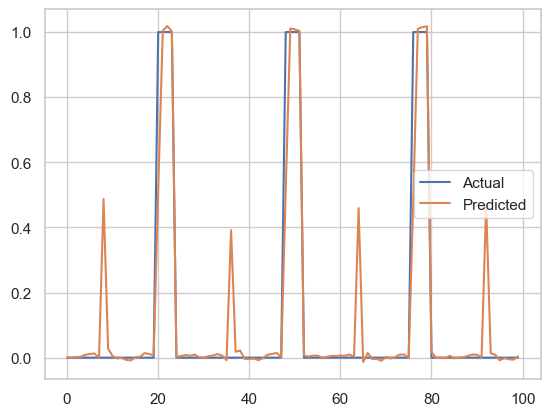

In [45]:
y_pred = model_lstm.predict(X_test_seq)

# Plot a few examples
plt.plot(y_test_seq[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.legend()
plt.show()

In [46]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate mean squared error
mse = mean_squared_error(y_test_seq, pred_lstm)
print(f'Mean Squared Error: {mse}')

# Calculate root mean squared error
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 0.0180142061360685
Root Mean Squared Error: 0.1342170113512758


# Training using GRU

In [48]:
model_gru = Sequential()
model_gru.add(GRU(25, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model_gru.add(tf.keras.layers.Dense(1))
#custom_optimizer = Adam(learning_rate=0.1)
model_gru.compile(optimizer=Adam(), loss='mse', metrics=['accuracy'])

In [50]:

gru_histry = model_gru.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_data=(X_test_seq, y_test_seq))

Epoch 1/50
868/868 [==============================] - 83s 96ms/step - loss: 0.0446 - accuracy: 0.9505 - val_loss: 0.0308 - val_accuracy: 0.9643
Epoch 2/50
868/868 [==============================] - 85s 98ms/step - loss: 0.0290 - accuracy: 0.9637 - val_loss: 0.0222 - val_accuracy: 0.9643
Epoch 3/50
868/868 [==============================] - 89s 102ms/step - loss: 0.0211 - accuracy: 0.9643 - val_loss: 0.0184 - val_accuracy: 0.9664
Epoch 4/50
868/868 [==============================] - 96s 111ms/step - loss: 0.0195 - accuracy: 0.9659 - val_loss: 0.0193 - val_accuracy: 0.9643
Epoch 5/50
868/868 [==============================] - 98s 113ms/step - loss: 0.0193 - accuracy: 0.9641 - val_loss: 0.0184 - val_accuracy: 0.9643
Epoch 6/50
868/868 [==============================] - 96s 111ms/step - loss: 0.0192 - accuracy: 0.9640 - val_loss: 0.0191 - val_accuracy: 0.9646
Epoch 7/50
868/868 [==============================] - 85s 98ms/step - loss: 0.0192 - accuracy: 0.9633 - val_loss: 0.0181 - val_accur

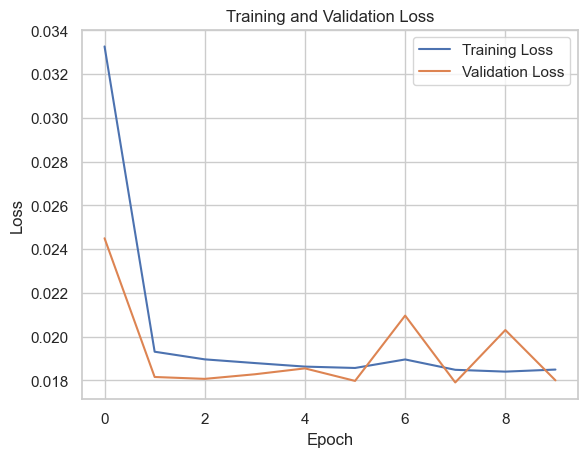

In [39]:
# training loss
plt.plot(gru_histry.history['loss'], label='Training Loss')

# validation loss
plt.plot(gru_histry.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

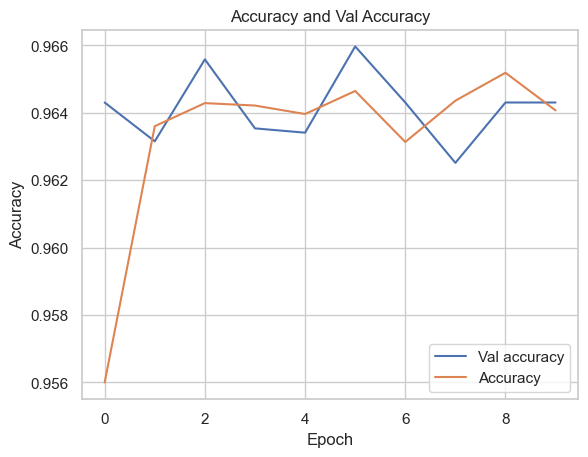

In [40]:
# Both Accuracy
plt.plot(gru_histry.history['val_accuracy'], label='Val accuracy')

# validation loss
plt.plot(gru_histry.history['accuracy'], label='Accuracy')

plt.title('Accuracy and Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.show()